In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from eodhd import APIClient

### Installing library

In [46]:
%pip install eodhd

Note: you may need to restart the kernel to use updated packages.


In [47]:
api = APIClient(api_key='68a888ecbf2185.97717291')

In [48]:
TICKERS = ["AAPL.US", "GOOGL.US", "TSLA.US", "JNJ.US", "JPM.US", "ITX.MC"]

**AAPL.US → Apple Inc.** (tecnología, iPhone, iPad, Mac).

**GOOGL.US → Alphabet Inc. Clase A** (matriz de Google, YouTube, Android).

**TSLA.US → Tesla Inc.** (vehículos eléctricos, baterías, energía).

**JNJ.US → Johnson & Johnson** (farmacéutica y productos de consumo, muy estable).

**JPM.US → JPMorgan Chase & Co.** (banco de inversión y comercial, uno de los más grandes del mundo).

**ITX.MC → Inditex S.A.** (España, grupo textil dueño de Zara, Pull&Bear, Massimo Dutti, etc., cotiza en la Bolsa de Madrid).

##### TICKERS DOWNLOAD

In [122]:
os.makedirs("../data", exist_ok=True)

for i in TICKERS:
    df = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol= i, period='d', from_date='2010-01-01'))
    df.to_csv(f'../data/{i}.csv', index=False)

### Data

In [84]:
df = pd.read_csv('../data/AAPL.US.csv', parse_dates=['date'])    #asegurar que los datos estan en orden
df = df.sort_values('date').reset_index(drop=True)
df

,date,open,high,low,close,adjusted_close,volume
0,2010-01-04,213.43000000,214.49960000,212.38000000,214.00960000,6.42460000,493729600
1,2010-01-05,214.60040000,215.58880000,213.25080000,214.37920000,6.43570000,601904800
2,2010-01-06,214.37920000,215.23040000,210.75040000,210.96880000,6.33330000,552160000
3,2010-01-07,211.75000000,211.99920000,209.05080000,210.57960000,6.32160000,477131200
4,2010-01-08,210.29960000,211.99920000,209.05920000,211.97960000,6.36370000,447610800
...,...,...,...,...,...,...,...
3932,2025-08-21,226.27000000,226.52000000,223.78000000,224.90000000,224.90000000,30621200
3933,2025-08-22,226.17000000,229.09000000,225.41000000,227.76000000,227.76000000,42477800
3934,2025-08-25,226.48000000,229.30000000,226.23000000,227.16000000,227.16000000,30983100
3935,2025-08-26,226.87000000,229.49000000,224.69000000,229.31000000,229.31000000,54575100


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3937 non-null   datetime64[ns]
 1   open            3937 non-null   float64       
 2   high            3937 non-null   float64       
 3   low             3937 non-null   float64       
 4   close           3937 non-null   float64       
 5   adjusted_close  3937 non-null   float64       
 6   volume          3937 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 215.4 KB


In [86]:
df.describe()

,date,open,high,low,close,adjusted_close,volume
count,3937,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000
mean,2017-10-28 08:18:53.858267648,243.77163261,246.17173757,241.29382692,243.82123790,73.52254140,222762306.24053848
min,2010-01-04 00:00:00,90.00000000,90.70000000,89.47000000,90.28000000,5.76540000,23234700.00000000
25%,2013-11-29 00:00:00,141.69000000,143.25000000,140.26000000,141.83000000,17.98510000,80528400.00000000
50%,2017-10-26 00:00:00,187.79000000,189.31000000,186.14000000,188.01000000,37.20220000,134322000.00000000
75%,2021-09-24 00:00:00,315.26880000,317.74960000,312.09000000,315.24000000,138.92620000,298138400.00000000
max,2025-08-27 00:00:00,702.41080000,705.07080000,699.56880000,702.10000000,258.10380000,1880998000.00000000
std,NaN,144.96295853,146.21232437,143.43679478,144.84435362,70.68288258,216322940.52632552


In [87]:
df.isnull().value_counts()

date   open   high   low    close  adjusted_close  volume
False  False  False  False  False  False           False     3937
Name: count, dtype: int64

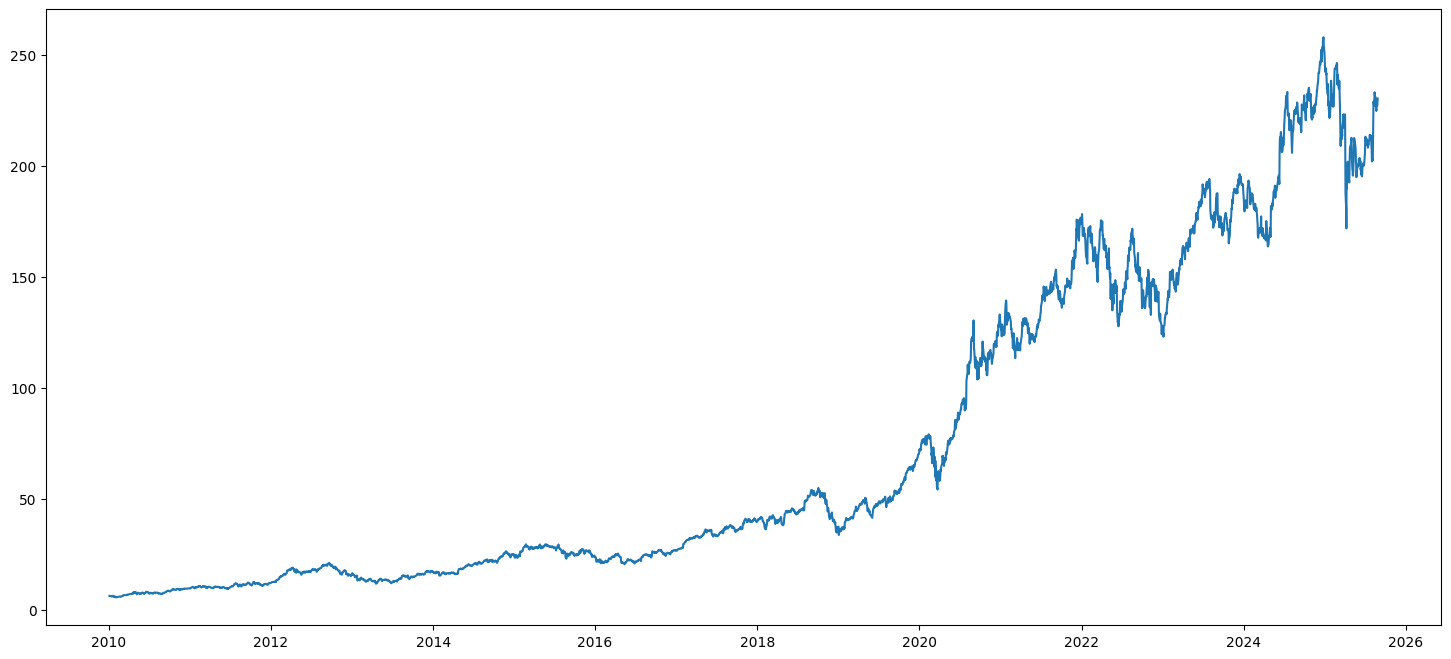

In [88]:
plt.figure(figsize=(18,8))
plt.plot(df["date"], df["adjusted_close"])

### Feature engineering

##### NO ESTACIONARIA

In [89]:
print('p-value:', adfuller(df.adjusted_close)[1])

p-value: 0.9915828600900267


##### ESTACIONARIA

In [90]:
print('p-value:', adfuller(df.adjusted_close.diff(periods = 1).dropna())[1])

p-value: 1.3503727995816538e-21


Vimos que al diferenciar una vez los valores originales, la serie se volvió estacionaria. Pero este proceso también metió algo de ruido en los datos. Para compensarlo, añadimos una nueva variable que ayuda al modelo a explicar esas variaciones extra y, con ello, a entender mejor los patrones reales que hay en la serie.

In [91]:
df["close_diff_1"] = df.adjusted_close.diff(periods=1)

Creamos columnas para apoyar la estacionariedad

In [92]:
df.index = df["date"]
df.drop("date", axis=1, inplace=True)

df.index = pd.to_datetime(df.index)
df = df.copy()
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

##### Autocorrelación parcial (Partial Autocorrelation, PACF)

##### Autocorrelación (ACF)
La **autocorrelación** mide cuánto se parece una serie a sí misma con cierto **retardo (lag)**.  

- Lag 1: relación entre \(y_t\) y \(y_{t-1}\)  
- Lag 2: relación entre \(y_t\) y \(y_{t-2}\)  
- etc.  

Se calcula con la función de autocorrelación (ACF).

---

##### Autocorrelación parcial (PACF)
La **autocorrelación parcial** mide la **relación directa** entre \(y_t\) y \(y_{t-k}\), eliminando la influencia de los lags intermedios.

- **ACF** = relación total (directa + indirecta).  
- **PACF** = relación directa (pura).

---

##### Utilidad en modelos ARIMA
En los modelos ARIMA:  
- La **ACF** ayuda a identificar el orden de la parte **MA (Moving Average)**.  
- La **PACF** ayuda a identificar el orden de la parte **AR (Autoregressive)**.  

Ejemplo:  
- Si la PACF corta en lag 2, puede sugerir un modelo **AR(2)**.  
- Si la ACF corta en lag 1, puede sugerir un modelo **MA(1)**.

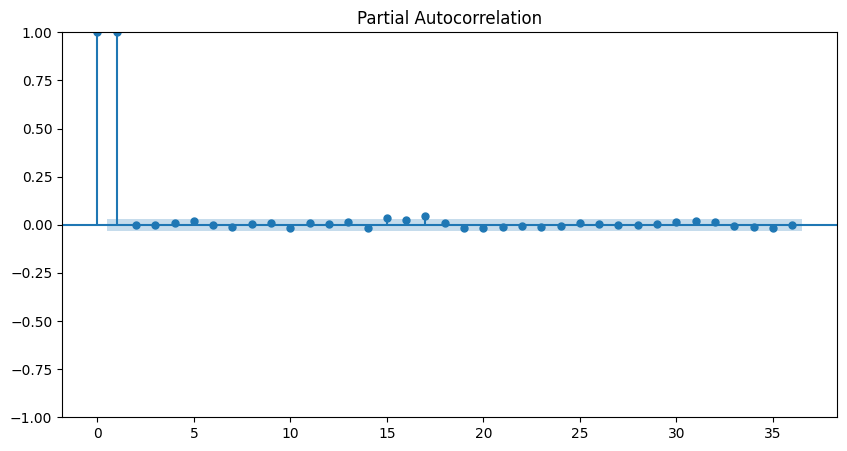

In [93]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['adjusted_close'], method='ywm')
plt.show()

Los datos muestran una autocorrelación significativa en el lag 1. Por lo tanto, introduciremos una variable que represente el precio lag en 1 periodo.

In [94]:
df["adjusted_close(-1)"] = df['adjusted_close'].shift(1)

Vamos a crear algunos de los indicadores técnicos mas conocidos para analizar las finanzas

In [95]:
df["SMA"] = df["adjusted_close"].rolling(window= 13).mean()

df["EMA"] = df["adjusted_close"].ewm(span=9).mean()

short_EMA = df["adjusted_close"].ewm(span=24).mean()
long_EMA = df["adjusted_close"].ewm(span=52).mean()

df["MACD"] = short_EMA - long_EMA

delta = df["adjusted_close"].diff()
delta = delta[1:]
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(com =14-1, min_periods=14).mean()
ema_down = down.ewm(com=14-1, min_periods=14).mean()

df["rsi_14"] = ema_up/ema_down

middle_band = df["adjusted_close"].rolling(window=10).mean()
std_dev = df["adjusted_close"].rolling(window=10).std()

df["Upper_Band"] = middle_band + (std_dev*2)
df["Lower_Band"] = middle_band - (std_dev*2)

``Simple Moving Average (SMA)``: Averages the closing prices over a specified window, smoothing out price fluctuations and highlighting trends.

``Exponential Moving Average (EMA):`` Similar to SMA, EMA gives more weight to recent prices, making it sensitive to short-term price movements.

``Moving Average Convergence Divergence (MACD):`` Represents the difference between short-term EMA and long-term EMA, providing insights into the strength and direction of a trend.

``Relative Strength Index (RSI):`` Measures the speed and change of price movements, indicating overbought or oversold conditions in the market.

Bollinger Bands: Consist of a ``middle band (SMA) and upper/lower bands`` representing price volatility. They help identify price extremes and potential reversal points.

In [96]:
df["H_L_diff"] = df["high"] - df["low"]

In [97]:
df.drop("close", axis=1, inplace=True)
df.drop("high", axis=1, inplace=True)
df.drop("low", axis=1, inplace=True)

In [98]:
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]

In [99]:
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)

In [100]:
df["target"] = df["adjusted_close"].shift(-1)

In [101]:
df.tail()

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-21,226.27000000,224.90000000,30621200,-1.11000000,3,3,8,2025,233,21,34,226.01000000,225.49683846,226.75277553,5.71912505,1.39387347,2.74000000,11.28760658,227.76000000
2025-08-22,226.17000000,227.76000000,42477800,2.86000000,4,3,8,2025,234,22,34,224.90000000,227.42530000,226.95422042,5.80422340,1.61053640,3.68000000,11.51705595,227.16000000
2025-08-25,226.48000000,227.16000000,30983100,-0.60000000,0,3,8,2025,237,25,35,227.76000000,228.51389231,226.99537634,5.83667884,1.53537927,3.07000000,11.52413583,229.31000000
2025-08-26,226.87000000,229.31000000,54575100,2.15000000,1,3,8,2025,238,26,35,227.16000000,229.24692308,227.45830107,5.93865886,1.71546178,4.80000000,11.52235238,230.49000000
2025-08-27,228.58000000,230.49000000,30134069,1.18000000,2,3,8,2025,239,27,35,229.31000000,229.35461538,228.06464086,6.06088370,1.82190054,2.60500000,10.30912864,NaN


In [102]:
df.describe()

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
count,3937.00000000,3937.00000000,3937.00000000,3936.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3937.00000000,3936.00000000,3925.00000000,3937.00000000,3937.00000000,3923.00000000,3937.00000000,3928.00000000,3936.00000000
mean,243.77163261,73.52254140,222762306.24053848,0.05692718,2.02336805,2.48793498,6.46075692,2017.32994666,181.21691643,15.72212344,26.25908052,73.48266146,73.38779420,73.29729667,0.73093969,1.49072193,4.87791064,6.21960876,73.53958864
std,144.96295853,70.68288258,216322940.52632552,1.82480335,1.39920947,1.10978612,3.41014846,4.52029073,104.18080159,8.74773494,14.87433590,70.64755130,70.43096018,70.49297837,2.46683085,0.98264357,4.18413249,7.66769676,70.68376846
min,90.00000000,5.76540000,23234700.00000000,-20.64940000,0.00000000,1.00000000,1.00000000,2010.00000000,2.00000000,1.00000000,1.00000000,5.76540000,5.90373846,5.89832882,-10.51540728,0.25090459,0.58000000,0.11363242,5.76540000
25%,141.69000000,17.98510000,80528400.00000000,-0.24757500,1.00000000,2.00000000,4.00000000,2013.00000000,91.00000000,8.00000000,13.00000000,17.98360000,17.95989231,17.82409909,-0.05871843,0.83180847,2.20000000,1.20010769,17.99050000
50%,187.79000000,37.20220000,134322000.00000000,0.02645000,2.00000000,2.00000000,6.00000000,2017.00000000,180.00000000,16.00000000,26.00000000,37.19595000,37.28696154,37.06157020,0.36024798,1.22833694,3.51000000,2.53379280,37.22365000
75%,315.26880000,138.92620000,298138400.00000000,0.37420000,3.00000000,3.00000000,9.00000000,2021.00000000,271.00000000,23.00000000,39.00000000,138.85097500,139.66368462,139.53387439,1.26265383,1.83849396,6.08000000,9.31446068,138.93962500
max,702.41080000,258.10380000,1880998000.00000000,26.36550000,4.00000000,4.00000000,12.00000000,2025.00000000,366.00000000,31.00000000,53.00000000,258.10380000,251.69421538,252.98788092,12.42873276,9.74576036,58.99880000,79.72860193,258.10380000


##### Extraemos el ultimo valor
Es para simular la prediccion de mañana

In [103]:
last_row = df.tail(1)
df.drop(df.tail(1).index, inplace=True)
df.dropna(inplace=True)

In [104]:
last_row

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-27,228.58000000,230.49000000,30134069,1.18000000,2,3,8,2025,239,27,35,229.31000000,229.35461538,228.06464086,6.06088370,1.82190054,2.60500000,10.30912864,NaN


##### Escalados

In [105]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [106]:
def train_test_split(df, test_size=0.2):
    data = df.values
    
    feature_scaler.fit(data[:, :-1]) 
    target_scaler.fit(data[:, -1:]) 
    scaled_data = feature_scaler.transform(data[:, :-1])
    scaled_target = target_scaler.transform(data[:, -1:])
    data_scaled = np.concatenate((scaled_data, scaled_target), axis=1)
    
    
    n = int(len(data_scaled) * (1 - test_size))
    return data_scaled[:n], data_scaled[n:]

In [107]:
def xgb_prediction(train, value):
    train = np.array(train)
    X, Y = train[:, :-1], train[:, -1]
    global model                                                                 # global model hace que pille la variable model fuera de la funcion, siendo asi una variable global y no una local
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

    model.fit(X, Y)
    val = np.array(value).reshape(1, -1)
    prediction = model.predict(val)
    return prediction[0] 

In [108]:
# def xgb_prediction(train, value, param_grid=None, n_splits=5, random_state=42):
#     """
#     train: array-like (n_samples, n_features + 1) -> última columna = y
#     value: array-like (n_features,) -> vector de features para predecir
#     param_grid: dict con el grid de hiperparámetros (opcional)
#     n_splits: nº de splits para TimeSeriesSplit
#     """
#     train = np.asarray(train)
#     X, y = train[:, :-1], train[:, -1]

#     # Split temporal (sin barajar). Asegura que haya al menos 2 folds válidos.
#     n_splits = max(3, min(n_splits, len(X) - 1))
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # Modelo base (sin early stopping)
#     base_model = XGBRegressor(
#         objective="reg:squarederror",
#         tree_method="hist",       # "gpu_hist" si tienes GPU
#         device = "cuda",
#         eval_metric="rmse",
#         random_state=random_state,
#         n_jobs=-1
#     )

#     # Grid por defecto (puedes pasarlo desde fuera si quieres algo distinto)
#     if param_grid is None:
#         param_grid = {
#             "max_depth": [3, 4, 5],
#             "min_child_weight": [1, 2, 3],
#             "subsample": [0.6, 0.8, 0.9],
#             "colsample_bytree": [0.6, 0.8, 0.9],
#             "reg_alpha": [0.01, 0.1, 0.5],
#             "reg_lambda": [0.1, 1.0, 5.0],
#             "learning_rate": [0.01, 0.02, 0.03, 0.05],
#             "n_estimators": [500, 1000, 1500, 2000]
#         }

#     # Usamos N-MSE (sklearn lo maximiza en negativo), luego convertimos a RMSE
#     grid = GridSearchCV(
#         estimator=base_model,
#         param_grid=param_grid,
#         scoring="neg_mean_squared_error",
#         cv=tscv,
#         refit=True,
#         verbose=0,
#         n_jobs=-1
#     )

#     grid.fit(X, y)
#     best_model = grid.best_estimator_
#     best_params = grid.best_params_
#     best_rmse_cv = np.sqrt(-grid.best_score_)  # RMSE promedio en CV

#     # Predicción del valor pedido
#     val = np.asarray(value).reshape(1, -1)
#     pred = best_model.predict(val)[0]

#     return pred, best_model, best_params, best_rmse_cv

In [109]:
def walk_forward_validation(data, percentage=0.2):
    # In this case -1 is the target column (last one)
    train, test = train_test_split(data, percentage)
    predictions = []
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_Y = test[i, :-1], test[i, -1] 
        pred = xgb_prediction(history, test_X) 
        predictions.append(pred)
        history.append(test[i])
    
    Y_test = target_scaler.inverse_transform(test[:, -1:].reshape(1, -1))
    Y_pred = target_scaler.inverse_transform(np.array(predictions).reshape(1, -1))
    test_rmse = metrics.root_mean_squared_error(Y_test, Y_pred)

    return test_rmse, Y_test, Y_pred

In [110]:
test_rmse, Y_test, predictions = walk_forward_validation(df, 0.2)

In [111]:
def plot_values(df, percentage=0.2):

    train, test = train_test_split(df, percentage)
    X, Y = train[:, :-1], train[:, -1]
    train_predictions = model.predict(X)
    
    # desescalar
    train_predictions = target_scaler.inverse_transform(train_predictions.reshape(-1, 1))
    Y = target_scaler.inverse_transform(Y.reshape(-1, 1))
    train_rmse = metrics.root_mean_squared_error(Y, train_predictions)
    
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

    # plot actual vs. predicted
    # concatenar Y e Y_test para plotearlo junto
    Y = Y.reshape(-1)
    train_predictions = train_predictions.reshape(-1)
    Y = np.concatenate((Y, Y_test.reshape(-1)), axis=0)
    new_predictions = np.concatenate((train_predictions, predictions.reshape(-1)), axis=0)
    plt.plot(new_predictions, label='Predicted')
    plt.plot(Y, label='Actual')  
    plt.legend()
    plt.show()

Training RMSE: 0.29657362426802236
Testing RMSE: 3.1277463219670585


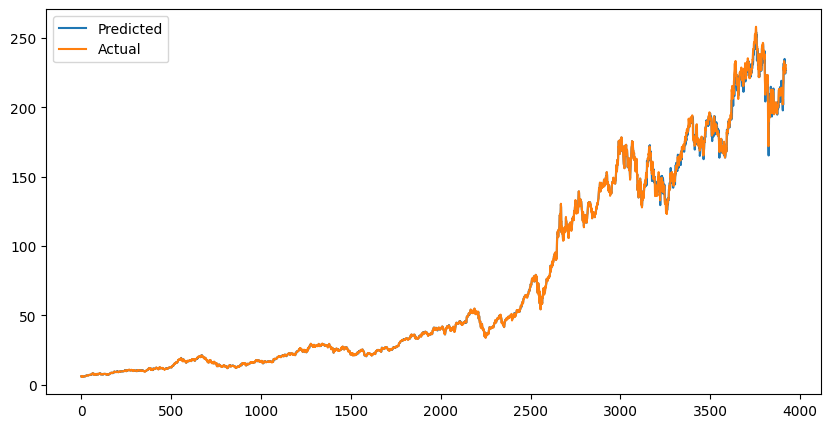

In [112]:
plot_values(df, 0.2)

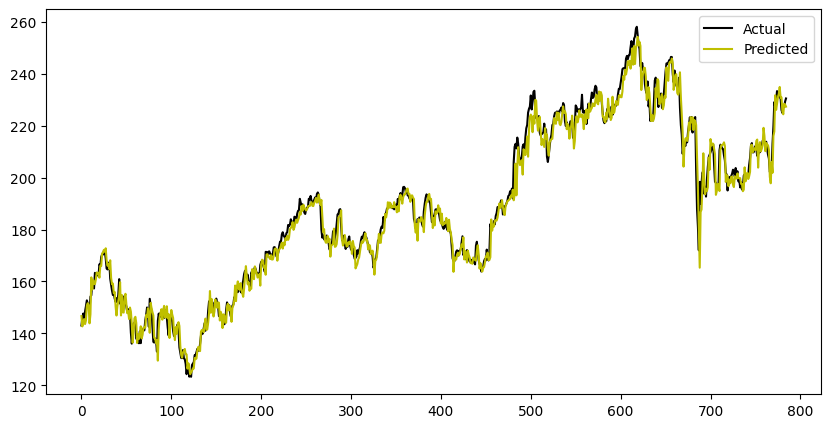

In [113]:
plt.plot(Y_test.reshape(-1), label='Actual', color='k')
plt.plot(predictions.reshape(-1), label='Predicted', color='y')
plt.legend()
plt.show()

#### Prediciendo el dia siguiente

In [114]:
last_row

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-27,228.58000000,230.49000000,30134069,1.18000000,2,3,8,2025,239,27,35,229.31000000,229.35461538,228.06464086,6.06088370,1.82190054,2.60500000,10.30912864,NaN


In [115]:
prediction = xgb_prediction(df.values, last_row.values[0][:-1])
prediction

229.59702

In [116]:
model.save_model('model.json')

In [117]:
# # Create an empty model object
# loaded_model = xgb.Booster()

# # Load from the JSON file
# loaded_model.load_model('model.json')

# # Use it for predictions
# preds = loaded_model.predict(dtest)